# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [34]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

In [35]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

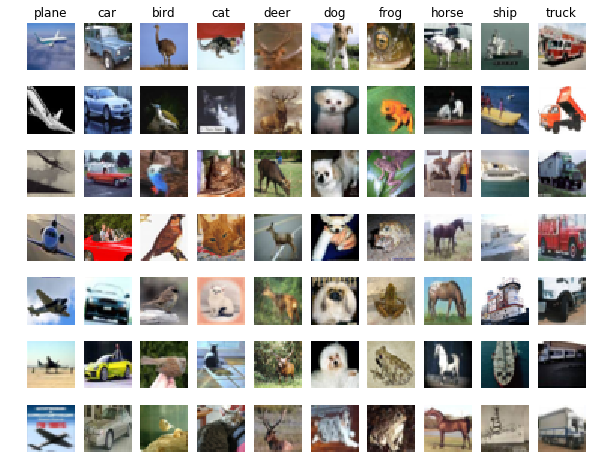

In [37]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Они больше == глубже. Также с какого-то момента появилась фишка использования многих фильтров сразу, апотом их слияния. А также сосединения НЕсоседких слоев (во имя незатухания градиентов). 

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Они очень большие, поэтому их обучать надо долго - ну это проблема. Также увеличение глубины вызывает затухание градиента :С

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Мало данных, сеть не сможет нормально обучиться на распознавание "любых" котиков. Решение - можно попробовать взять претренированную сеть и дообучить ее(добавленные штуки). Так как тогда большое количество весов ббудет обучено на большом количестве данных.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Идея:
1. Стайл трансфер для картинок - это сделать функцию потерь, зависящей от изображения, под стиль которого подгоняем. ТО есть чем ближе картинка к картинке стиля - тем лучше. 
2. Про музыку. На лекции было показано, что из музыки можно сделать картинку - а дальше можно использовать стайл трансфер для картинок.

Вот. Это идея.

In [38]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer", dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [39]:
import sys
sys.setrecursionlimit(10000)
import lasagne
from lasagne.nonlinearities import rectify, softmax, sigmoid
from lasagne.layers import InputLayer, MaxPool2DLayer, DenseLayer, DropoutLayer, helper, batch_norm, BatchNormLayer
# for ResNet
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer, ElemwiseSumLayer, NonlinearityLayer, PadLayer, GlobalPoolLayer, ExpressionLayer
from lasagne.init import Orthogonal, HeNormal, GlorotNormal

PIXELS = 32
imageSize = PIXELS * PIXELS
num_features = imageSize * 3

he_norm = HeNormal(gain='relu')

def ResNet_FullPreActivation(input_var=None, n=18):
    '''
    Adapted from https://github.com/Lasagne/Recipes/tree/master/papers/deep_residual_learning.
    Tweaked to be consistent with 'Identity Mappings in Deep Residual Networks', Kaiming He et al. 2016 (https://arxiv.org/abs/1603.05027)

    Forumala to figure out depth: 6n + 2
    '''
    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=True, first=False):
        input_num_filters = l.output_shape[1]
        if increase_dim:
            first_stride = (2,2)
            out_num_filters = input_num_filters*2
        else:
            first_stride = (1,1)
            out_num_filters = input_num_filters

        if first:
            # hacky solution to keep layers correct
            bn_pre_relu = l
        else:
            # contains the BN -> ReLU portion, steps 1 to 2
            bn_pre_conv = BatchNormLayer(l)
            bn_pre_relu = NonlinearityLayer(bn_pre_conv, rectify)

        # contains the weight -> BN -> ReLU portion, steps 3 to 5
        conv_1 = batch_norm(ConvLayer(bn_pre_relu, num_filters=out_num_filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=he_norm))

        # contains the last weight portion, step 6
        conv_2 = ConvLayer(conv_1, num_filters=out_num_filters, filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=he_norm)

        # add shortcut connections
        if increase_dim:
            # projection shortcut, as option B in paper
            projection = ConvLayer(bn_pre_relu, num_filters=out_num_filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_2, projection])
        else:
            block = ElemwiseSumLayer([conv_2, l])

        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, PIXELS, PIXELS), input_var=input_var)

    # first layer, output is 16 x 32 x 32
    l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=he_norm))

    # first stack of residual blocks, output is 16 x 32 x 32
    l = residual_block(l, first=True)
    for _ in range(1,n):
        l = residual_block(l)

    # second stack of residual blocks, output is 32 x 16 x 16
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)

    # third stack of residual blocks, output is 64 x 8 x 8
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)

    bn_post_conv = BatchNormLayer(l)
    bn_post_relu = NonlinearityLayer(bn_post_conv, rectify)

    # average pooling
    avg_pool = GlobalPoolLayer(bn_post_relu)

    # fully connected layer
    network = DenseLayer(avg_pool, num_units=10, W=HeNormal(), nonlinearity=softmax)

    return network

# ========================================================================================================================

def ResNet_BottleNeck_FullPreActivation(input_var=None, n=18):
    '''
    Adapted from https://github.com/Lasagne/Recipes/tree/master/papers/deep_residual_learning.
    Tweaked to be consistent with 'Identity Mappings in Deep Residual Networks', Kaiming He et al. 2016 (https://arxiv.org/abs/1603.05027)

    Judging from https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua.
    Number of filters go 16 -> 64 -> 128 -> 256

    Forumala to figure out depth: 9n + 2
    '''

    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_bottleneck_block(l, increase_dim=False, first=False):
        input_num_filters = l.output_shape[1]

        if increase_dim:
            first_stride = (2,2)
            out_num_filters = input_num_filters * 2
        else:
            first_stride = (1,1)
            out_num_filters = input_num_filters

        if first:
            # hacky solution to keep layers correct
            bn_pre_relu = l
            out_num_filters = out_num_filters * 4
        else:
            # contains the BN -> ReLU portion, steps 1 to 2
            bn_pre_conv = BatchNormLayer(l)
            bn_pre_relu = NonlinearityLayer(bn_pre_conv, rectify)

        bottleneck_filters = out_num_filters / 4

        # contains the weight -> BN -> ReLU portion, steps 3 to 5
        conv_1 = batch_norm(ConvLayer(bn_pre_relu, num_filters=bottleneck_filters, filter_size=(1,1), stride=(1,1), nonlinearity=rectify, pad='same', W=he_norm))

        conv_2 = batch_norm(ConvLayer(conv_1, num_filters=bottleneck_filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=he_norm))

        # contains the last weight portion, step 6
        conv_3 = ConvLayer(conv_2, num_filters=out_num_filters, filter_size=(1,1), stride=(1,1), nonlinearity=None, pad='same', W=he_norm)

        if increase_dim:
            # projection shortcut, as option B in paper
            projection = ConvLayer(bn_pre_relu, num_filters=out_num_filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_3, projection])

        elif first:
            # projection shortcut, as option B in paper
            projection = ConvLayer(l, num_filters=out_num_filters, filter_size=(1,1), stride=(1,1), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_3, projection])

        else:
            block = ElemwiseSumLayer([conv_3, l])

        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, PIXELS, PIXELS), input_var=input_var)

    # first layer, output is 16x16x16
    l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=he_norm))

    # first stack of residual blocks, output is 64x16x16
    l = residual_bottleneck_block(l, first=True)
    for _ in range(1,n):
        l = residual_bottleneck_block(l)

    # second stack of residual blocks, output is 128x8x8
    l = residual_bottleneck_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_bottleneck_block(l)

    # third stack of residual blocks, output is 256x4x4
    l = residual_bottleneck_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_bottleneck_block(l)

    bn_post_conv = BatchNormLayer(l)
    bn_post_relu = NonlinearityLayer(bn_post_conv, rectify)

    # average pooling
    avg_pool = GlobalPoolLayer(bn_post_relu)

    # fully connected layer
    network = DenseLayer(avg_pool, num_units=10, W=HeNormal(), nonlinearity=softmax)

    return network

# ========================================================================================================================

def ResNet_FullPre_Wide(input_var=None, n=6, k=4):
    '''
    Adapted from https://github.com/Lasagne/Recipes/tree/master/papers/deep_residual_learning.

    Tweaked to be consistent with 'Identity Mappings in Deep Residual Networks', Kaiming He et al. 2016 (https://arxiv.org/abs/1603.05027)

    And 'Wide Residual Networks', Sergey Zagoruyko, Nikos Komodakis 2016 (http://arxiv.org/pdf/1605.07146v1.pdf)

    Depth = 6n + 2
    '''
    n_filters = {0:16, 1:16*k, 2:32*k, 3:64*k}

    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=True, first=False, filters=16):
        if increase_dim:
            first_stride = (2,2)
        else:
            first_stride = (1,1)

        if first:
            # hacky solution to keep layers correct
            bn_pre_relu = l
        else:
            # contains the BN -> ReLU portion, steps 1 to 2
            bn_pre_conv = BatchNormLayer(l)
            bn_pre_relu = NonlinearityLayer(bn_pre_conv, rectify)

        # contains the weight -> BN -> ReLU portion, steps 3 to 5
        conv_1 = batch_norm(ConvLayer(bn_pre_relu, num_filters=filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=he_norm))

        #dropout = DropoutLayer(conv_1, p=0.3)

        # contains the last weight portion, step 6
        conv_2 = ConvLayer(conv_1, num_filters=filters, filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=he_norm)

        # add shortcut connections
        if increase_dim:
            # projection shortcut, as option B in paper
            projection = ConvLayer(bn_pre_relu, num_filters=filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_2, projection])

        elif first:
            # projection shortcut, as option B in paper
            projection = ConvLayer(l, num_filters=filters, filter_size=(1,1), stride=(1,1), nonlinearity=None, pad='same', b=None)
            block = ElemwiseSumLayer([conv_2, projection])

        else:
            block = ElemwiseSumLayer([conv_2, l])

        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, PIXELS, PIXELS), input_var=input_var)

    # first layer, output is 16 x 64 x 64
    l = batch_norm(ConvLayer(l_in, num_filters=n_filters[0], filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=he_norm))

    # first stack of residual blocks, output is 32 x 64 x 64
    l = residual_block(l, first=True, filters=n_filters[1])
    for _ in range(1,n):
        l = residual_block(l, filters=n_filters[1])

    # second stack of residual blocks, output is 64 x 32 x 32
    l = residual_block(l, increase_dim=True, filters=n_filters[2])
    for _ in range(1,(n+2)):
        l = residual_block(l, filters=n_filters[2])

    # third stack of residual blocks, output is 128 x 16 x 16
    l = residual_block(l, increase_dim=True, filters=n_filters[3])
    for _ in range(1,(n+2)):
        l = residual_block(l, filters=n_filters[3])

    bn_post_conv = BatchNormLayer(l)
    bn_post_relu = NonlinearityLayer(bn_post_conv, rectify)

    # average pooling
    avg_pool = GlobalPoolLayer(bn_post_relu)

    # fully connected layer
    network = DenseLayer(avg_pool, num_units=10, W=HeNormal(), nonlinearity=softmax)

    return network

In [40]:
net = ResNet_FullPre_Wide(input_var=input_X)

In [41]:
# net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

# net = lasagne.layers.Conv2DLayer(net, num_filters=10, filter_size=(5, 5),
#                                  W=lasagne.init.GlorotUniform())

# net = lasagne.layers.DenseLayer(net, num_units = 10, nonlinearity=softmax)

In [42]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print(all_weights)

[W, beta, gamma, W, beta, gamma, W, b, W, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, W, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, W, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, beta, gamma, W, b, beta, gamma, W, b]


In [43]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = T.mean(T.eq(T.argmax(y_predicted, axis=1), target_y),
                      dtype=theano.config.floatX)

In [44]:
updates = lasagne.updates.nesterov_momentum(
            loss, all_weights, learning_rate=0.01, momentum=0.9)

In [45]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates,
                           allow_input_downcast=True)

In [46]:
accuracy_fun = theano.function([input_X, target_y], accuracy,
                              allow_input_downcast=True)

### Вот и всё, пошли её учить

In [47]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [48]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

#     # And a full pass over the validation data:
#     val_acc = 0
#     val_batches = 0
#     for batch in iterate_minibatches(X_val, y_val, batch_size):
#         inputs, targets = batch
#         val_acc += accuracy_fun(inputs, targets)
#         val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
#     print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 10 took 860.807s
  training loss (in-iteration):		1.271588
  train accuracy:		53.60 %
Epoch 2 of 10 took 860.913s
  training loss (in-iteration):		0.765789
  train accuracy:		73.27 %
Epoch 3 of 10 took 860.172s
  training loss (in-iteration):		0.542704
  train accuracy:		81.30 %
Epoch 4 of 10 took 860.832s
  training loss (in-iteration):		0.399270
  train accuracy:		86.23 %
Epoch 5 of 10 took 860.387s
  training loss (in-iteration):		0.307163
  train accuracy:		89.46 %
Epoch 6 of 10 took 860.882s
  training loss (in-iteration):		0.242777
  train accuracy:		91.42 %
Epoch 7 of 10 took 860.457s
  training loss (in-iteration):		0.183651
  train accuracy:		93.55 %
Epoch 8 of 10 took 860.255s
  training loss (in-iteration):		0.148888
  train accuracy:		94.70 %
Epoch 9 of 10 took 860.105s
  training loss (in-iteration):		0.113155
  train accuracy:		96.00 %
Epoch 10 of 10 took 860.029s
  training loss (in-iteration):		0.089137
  train accuracy:		96.91 %


In [50]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		81.77 %
Нужно больше магии!


В общем. Кажется, надо добавить регуляризацию. Я пробовала 2 константы регуляризационные, они дали результат чуть меньше и сильно меньше соответственно. Возможно, нужно было взять другую регуляризационную костанту. Так же выяснено, что на 7 эпохах результат на тесте получается лучше (тоже своеобразная регуляризация, но результат не удалось сохранить :( ) Он был 82.6%. Вот. Вообще я бы еще много чего попробовала, но я ОЧЕНЬ потно настраивала сервер и преуспела совсем недавно, поэтому только так пока :С

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 